In [132]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.train_bn import parameter_learning, component
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from scipy import stats
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc, parall_accuracy
import cpuinfo
from scipy import integrate
import math
from scipy.linalg import sqrtm
from mpl_toolkits.mplot3d import Axes3D 
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc, LOO_validation, parall_accuracy
from joblib import Parallel, delayed
import cpuinfo
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import roc_auc_score
from sklearn.mixture import GaussianMixture
from operator import itemgetter 
from sklearn.preprocessing import KBinsDiscretizer
from scipy.spatial import distance
import matplotlib as mpl

In [15]:
def discriminant_distance(x1, x2, U):
    diff = np.abs(x1 - x2)
    diff_t = np.transpose(diff)
    U_t = np.transpose(U)
    UU = np.dot(U,U_t)
    d = np.dot(np.dot(diff_t, UU), diff)
    return d

In [2]:
def pdf_gmm(x, weights, means, covs):
    p = 0
    for i in range(len(weights)):
        p += weights[i] * stats.multivariate_normal.pdf(x, mean=means[i], cov=covs[i], allow_singular=True)
    return p

In [3]:
def gmm_kl_sklearn (gmm_p, gmm_q, n = 10**5):
    X = gmm_p.sample(n)[0]
    log_p = gmm_p.score_samples(X)
    log_q = gmm_q.score_samples(X)
    return log_p.mean() - log_q.mean()

In [29]:
def gmm_js_sklearn(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2

In [110]:
def gmm_js (gmm_p, gmm_q, n_samples=2000):
    w_p = gmm_p.priors
    mean_p = gmm_p.means
    cov_p = gmm_p.covariances

    w_q = gmm_q.priors
    mean_q = gmm_q.means
    cov_q = gmm_q.covariances
    
    X = gmm_p.sample(n_samples)
    
    log_p_x = []
    log_q_x = []
    while (len(log_p_x) == 0) | (len(log_q_x) == 0):
        for xi in X:
            pdf_p = pdf_gmm(xi, w_p, mean_p, cov_p)
            pdf_q = pdf_gmm(xi, w_q, mean_q, cov_q)
            if (pdf_p == 0) | (pdf_q == 0):
                continue
            else:
                log_p_x.append(math.log(pdf_p))
                log_q_x.append(math.log(pdf_q))
    log_p_x = np.array(log_p_x)
    log_q_x = np.array(log_q_x)
    log_mix_X = np.logaddexp(log_p_x, log_q_x)


    Y = gmm_q.sample(n_samples)
    log_p_y = []
    log_q_y = []
    while (len(log_p_y) == 0) | (len(log_q_y) == 0):
        for yi in Y:
            pdf_p = pdf_gmm(yi, w_p, mean_p, cov_p)
            pdf_q = pdf_gmm(yi, w_q, mean_q, cov_q)
            if (pdf_p == 0) | (pdf_q == 0):
                continue
            else:
                log_p_y.append(math.log(pdf_p))
                log_q_y.append(math.log(pdf_q))
    log_p_y = np.array(log_p_y)
    log_q_y = np.array(log_q_y)
    log_mix_Y = np.logaddexp(log_p_y, log_q_y)

    return (log_p_x.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_y.mean() - (log_mix_Y.mean() - np.log(2))) / 2
 

        


In [11]:
def olr (w, means, covs):
    n_comp = len(w)
    olr_values = []
    for i in range(n_comp):
        for j in range(i+1, n_comp, 1):
            delta = (np.array(means[j]) - np.array(means[i])) * 1/1000
            points = [np.array(means[i]) - 10*delta]
            current_point = np.array(means[i]) - 10*delta
            for k in range(1030):
                new_point = current_point + delta
                current_point = new_point
                points.append(new_point)
            w1 = w[i]
            w2 = w[j]
            w1_new = w1 / (w1 + w2)
            w2_new = 1 - w1_new
            w_new = [w1_new, w2_new]
            m_new = [means[i], means[j]]
            cov_new = [covs[i], covs[j]]
            peaks = []
            saddles = []
            for k in range(1, 1030, 1):
                pdf_k = pdf_gmm(points[k], w_new, m_new, cov_new)
                pdf_prev_k = pdf_gmm(points[k-1], w_new, m_new, cov_new)
                pdf_next_k = pdf_gmm(points[k+1], w_new, m_new, cov_new)
                if ((pdf_k - pdf_prev_k) > 0) & ((pdf_k - pdf_next_k) > 0):
                    peaks.append(pdf_k)
                if ((pdf_k - pdf_prev_k) < 0) & ((pdf_k - pdf_next_k) < 0):
                    saddles.append(pdf_k)
            olr_current = 0
            if len(peaks) == 1:
                olr_current = 1
            else:
                olr_current = saddles[0] / np.min(peaks)
            olr_values.append(olr_current)
    return olr_values

## Двумерная смесь
### Две компоненты

In [16]:
dist_matrix = []
means = []
covs = []
w = [1/2, 1/2]
for _ in range(300):
    print(_)
    mean = []
    cov = []
    for k in range(2):
        if k == 0:
            rand_m = [random.randint(0, 15), random.randint(0, 15)]
            while rand_m in mean:
                rand_m = [random.randint(0, 15), random.randint(0, 15)]
            mean.append(rand_m)
        if k == 1:
            rand_m = [random.randint(0, 15), random.randint(0, 15)]
            while rand_m in mean:
                rand_m = [random.randint(0, 15), random.randint(0, 15)]
            mean.append(rand_m)
        
        if _ < 100:
            cov.append(np.array([[ 1 , 0], [ 0,  1]]))
        if (_ >= 100) & (_ < 200):
            cov.append(np.array([[ 5 , 0], [ 0,  5]]))
        if _ >= 200:
            cov.append(np.array([[ 10 , 0], [ 0,  10]]))
    
    means.append(mean)
    covs.append(cov)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
olr_values = []
for i in range(300):
    m = means[i]
    c = covs[i]
    olr_values.append(olr(w, m, c))
    

-3.245321536308597 20.21575619888605 -4.083908336003173 3.9930566465593147


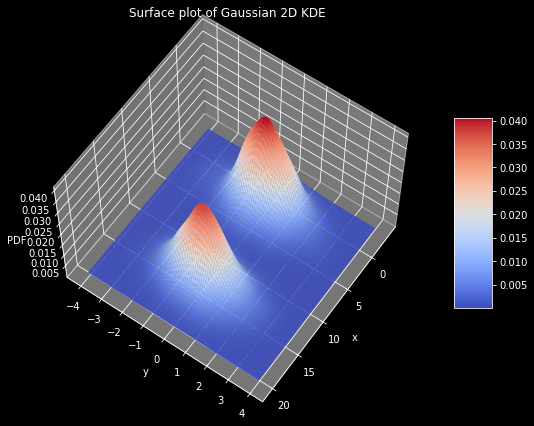

In [67]:
m = means[17]
c = covs[17]
#model = GMM(n_components=2, priors=w, means=m, covariances=c)
sample = X#model.sample(2000)
# z = []
# for el in X:
#   z.append(pdf_gmm(el,model_bn.priors, model_bn.means, model_bn.covariances))
# Extract x and y
x = sample[:, 0]
y = sample[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

In [26]:
mean_olr = []
for el in olr_values:
    mean_olr.append(np.mean(el))

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

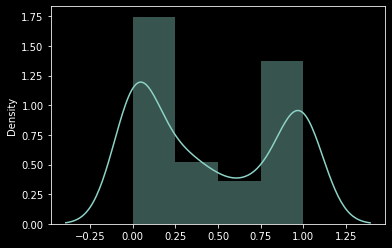

In [27]:
sns.distplot(mean_olr)

In [115]:
node_types = {'C1':'cont', 'C2':'cont'}
columns_for_disc = ['C1', 'C2']
js_mix = []
structures = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=2, priors=w, means=mean, covariances=cov)
    sample = model.sample(5000)
    #model = GaussianMixture(n_components=3, random_state=0).fit(sample)
    sample = pd.DataFrame(data=sample, columns=['C1', 'C2'])
    #bn_full = structure_learning(sample, 'HC', node_types, 'BIC')
    #structures.append(bn_full['E'])
    bn_full = dict()
    bn_full['V'] = ['C1', 'C2']
    bn_full['E'] = [['C1', 'C2']]
    params = parameter_learning(sample, node_types, bn_full, 'mix')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    synth_data = pd.DataFrame(all_bn.randomsample(5000, 'mix'))
    #model_bn = GaussianMixture(n_components=3, random_state=0).fit(synth_data.values)
    model_bn = GMM(n_components=2).from_samples(synth_data.values)
    js_mix.append(gmm_js(model, model_bn))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0, 0.5, 'Jensen Shannon divergence for GMM')

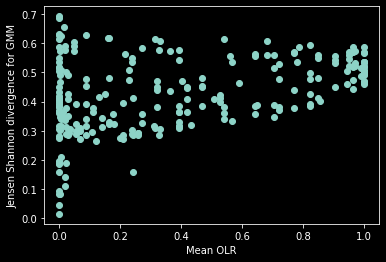

In [118]:
positive_index = []
for i in range(300):
    if js_mix[i] > 0:
        positive_index.append(i)
plt.scatter([mean_olr[i] for i in positive_index], [js_mix[i] for i in positive_index])
plt.xlabel('Mean OLR')
plt.ylabel('Jensen Shannon divergence for GMM')

In [119]:
node_types = {'C1':'cont', 'C2':'cont'}
columns_for_disc = ['C1', 'C2']
js_simple = []
structures = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=2, priors=w, means=mean, covariances=cov)
    sample = model.sample(5000)
    #model = GaussianMixture(n_components=3, random_state=0).fit(sample)
    sample = pd.DataFrame(data=sample, columns=['C1', 'C2'])
    #bn_full = structure_learning(sample, 'HC', node_types, 'BIC')
    #structures.append(bn_full['E'])
    bn_full = dict()
    bn_full['V'] = ['C1', 'C2']
    bn_full['E'] = [['C1', 'C2']]
    params = parameter_learning(sample, node_types, bn_full, 'simple')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    synth_data = pd.DataFrame(all_bn.randomsample(5000, 'simple'))
    #model_bn = GaussianMixture(n_components=3, random_state=0).fit(synth_data.values)
    model_bn = GMM(n_components=2).from_samples(synth_data.values)
    js_simple.append(gmm_js(model, model_bn))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0, 0.5, 'Jensen Shannon divergence for Gaussian dist')

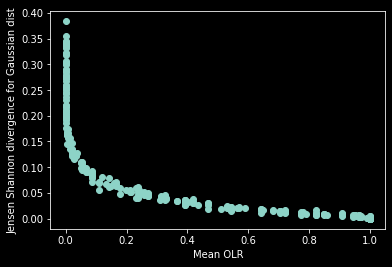

In [120]:
plt.scatter(mean_olr, js_simple)
plt.xlabel('Mean OLR')
plt.ylabel('Jensen Shannon divergence for Gaussian dist')

In [123]:
node_types = {'C1':'cont', 'C2':'cont'}
columns_for_disc = ['C1', 'C2']
rmse_mix = []
train_data = []
test_data = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=2, priors=w, means=mean, covariances=cov)
    sample = model.sample(5000)
    #model = GaussianMixture(n_components=3, random_state=0).fit(sample)
    sample = pd.DataFrame(data=sample, columns=['C1', 'C2'])
    train, test = train_test_split(sample, test_size=0.02)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    train_data.append(train)
    test_data.append(test)
    #bn_full = structure_learning(sample, 'HC', node_types, 'BIC')
    #structures.append(bn_full['E'])
    bn_full = dict()
    bn_full['V'] = ['C1', 'C2']
    bn_full['E'] = [['C1', 'C2']]
    params = parameter_learning(train, node_types, bn_full, 'mix')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, ind = parall_accuracy(all_bn, test, columns_for_disc, 'mix', 11)
    rmse_mix.append(rmse)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [126]:
mean_rmse_mix = []
for i in range(300):
    mean_rmse_mix.append((rmse_mix[i]['C1'] + rmse_mix[i]['C2']) / 2)


In [127]:
node_types = {'C1':'cont', 'C2':'cont'}
columns_for_disc = ['C1', 'C2']
rmse_simple = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    train = train_data[i]
    test = test_data[i]
    bn_full = dict()
    bn_full['V'] = ['C1', 'C2']
    bn_full['E'] = [['C1', 'C2']]
    params = parameter_learning(train, node_types, bn_full, 'simple')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, ind = parall_accuracy(all_bn, test, columns_for_disc, 'simple', 11)
    rmse_simple.append(rmse)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [128]:
mean_rmse_simple = []
for i in range(300):
    mean_rmse_simple.append((rmse_simple[i]['C1'] + rmse_simple[i]['C2']) / 2)

In [130]:
rmse_decrease = []
for i in range(300):
    rmse_decrease.append(100 - ((mean_rmse_mix[i] * 100) / mean_rmse_simple[i]))
    

Text(0, 0.5, 'RMSE decrease in %')

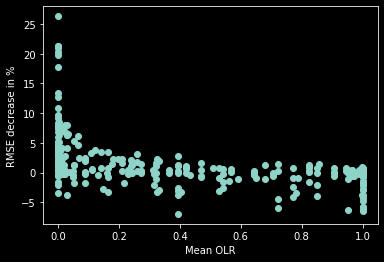

In [131]:
plt.scatter(mean_olr, rmse_decrease)
plt.xlabel('Mean OLR')
plt.ylabel('RMSE decrease in %')

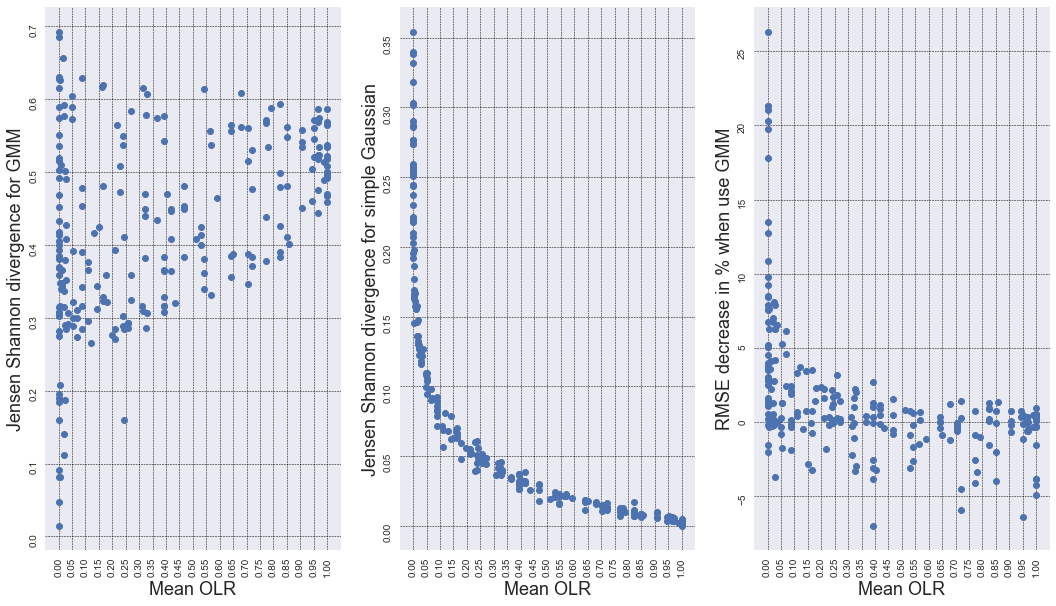

In [172]:
mpl.style.use('seaborn')
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
sns.set(font_scale=2)

axes[0].scatter([mean_olr[i] for i in positive_index], [js_mix[i] for i in positive_index])
axes[0].set_xlabel('Mean OLR', fontsize=18)
axes[0].set_ylabel('Jensen Shannon divergence for GMM', fontsize=18)
axes[0].grid(color = 'black', linestyle = '--', linewidth = 0.5)
plt.setp(axes, xticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
axes[0].tick_params(labelrotation=90)

axes[1].scatter([mean_olr[i] for i in positive_index], [js_simple[i] for i in positive_index])
axes[1].set_xlabel('Mean OLR', fontsize=18)
axes[1].set_ylabel('Jensen Shannon divergence for simple Gaussian', fontsize=18)
axes[1].grid(color = 'black', linestyle = '--', linewidth = 0.5)
axes[1].tick_params(labelrotation=90)

axes[2].scatter([mean_olr[i] for i in positive_index], [rmse_decrease[i] for i in positive_index])
axes[2].set_xlabel('Mean OLR', fontsize=18)
axes[2].set_ylabel('RMSE decrease in % when use GMM', fontsize=18)
axes[2].grid(color = 'black', linestyle = '--', linewidth = 0.5)
axes[2].tick_params(labelrotation=90)

In [156]:
df_2d_2comp = pd.DataFrame(columns=['means', 'covs', 'w', 'mean_olr', 'js_mix', 'js_simple', 'rmse_mix', 'rmse_simple'])
df_2d_2comp['means'] = means
df_2d_2comp['covs'] = covs
df_2d_2comp['w'] = [w]*300
df_2d_2comp['mean_olr'] = mean_olr
df_2d_2comp['js_mix'] = js_mix
df_2d_2comp['js_simple'] = js_simple
df_2d_2comp['rmse_mix'] = rmse_mix
df_2d_2comp['rmse_simple'] = rmse_simple

In [157]:
df_2d_2comp

,means,covs,w,mean_olr,js_mix,js_simple,rmse_mix,rmse_simple
0,"[[13, 3], [5, 9]]","[[[1, 0], [0, 1]], [[1, 0], [0, 1]]]","[0.5, 0.5]",0.000007,0.685587,0.258762,"{'C1': 4.228, 'C2': 1.033}","{'C1': 4.193, 'C2': 1.232}"
1,"[[3, 10], [13, 6]]","[[[1, 0], [0, 1]], [[1, 0], [0, 1]]]","[0.5, 0.5]",0.000001,-0.309430,0.275394,"{'C1': 5.302, 'C2': 0.978}","{'C1': 5.559, 'C2': 1.043}"
2,"[[9, 9], [15, 12]]","[[[1, 0], [0, 1]], [[1, 0], [0, 1]]]","[0.5, 0.5]",0.007213,0.510097,0.167148,"{'C1': 3.274, 'C2': 0.858}","{'C1': 3.276, 'C2': 0.975}"
3,"[[1, 15], [7, 12]]","[[[1, 0], [0, 1]], [[1, 0], [0, 1]]]","[0.5, 0.5]",0.007213,-0.015435,0.174411,"{'C1': 3.023, 'C2': 1.027}","{'C1': 3.043, 'C2': 1.164}"
4,"[[13, 5], [11, 11]]","[[[1, 0], [0, 1]], [[1, 0], [0, 1]]]","[0.5, 0.5]",0.013476,0.365169,0.157286,"{'C1': 1.336, 'C2': 2.201}","{'C1': 1.331, 'C2': 2.288}"
...,...,...,...,...,...,...,...,...
295,"[[14, 3], [1, 12]]","[[[10, 0], [0, 10]], [[10, 0], [0, 10]]]","[0.5, 0.5]",0.087874,0.316420,0.082516,"{'C1': 6.9, 'C2': 3.605}","{'C1': 6.891, 'C2': 3.815}"
296,"[[2, 3], [15, 1]]","[[[10, 0], [0, 10]], [[10, 0], [0, 10]]]","[0.5, 0.5]",0.230034,0.507857,0.059906,"{'C1': 7.072, 'C2': 2.381}","{'C1': 7.093, 'C2': 2.395}"
297,"[[7, 0], [0, 9]]","[[[10, 0], [0, 10]], [[10, 0], [0, 10]]]","[0.5, 0.5]",0.393227,0.316698,0.026440,"{'C1': 4.568, 'C2': 5.006}","{'C1': 4.587, 'C2': 4.751}"
298,"[[14, 8], [13, 5]]","[[[10, 0], [0, 10]], [[10, 0], [0, 10]]]","[0.5, 0.5]",1.000000,-0.724100,0.000408,"{'C1': 3.349, 'C2': 3.678}","{'C1': 3.342, 'C2': 3.698}"


In [158]:
df_2d_2comp.to_csv('2d_2comp.csv', index=False)